# Анализ работы программы лояльности в строительном магазине


## **Вводные данные**

**От** junior-аналитика *Захаровой Екатерины*

**Для** Строительного магазина «Строили, строили и наконец построили». Для менеджера проекта, который отвечает за программу лояльности

### Задачи исследования:

- провести исследовательский анализ данных и изучить общую картину;
- получить основные ритейл-метрики по когортам у клиентов внутри программы лояльности и вне ее;
- проанализировать эффективность текущей программы лояльности (повышаются ли показатели метрик);
- на основе эффективности дать рекомендации;
- проверить гипотезы;

### Информация о данных
**Период данных:**

Весь предоставленный период:
- с 2016-12-01 08:26:00,
- по 2017-02-28 17:04:00  

**Датасеты:**
- Запись о покупках
- Записи о ценах

### Описание полученных данных и программы лояльности:

* Датасет содержит данные о покупках в магазине строительных материалов «Строили, строили и наконец построили»;
* Записи, предоставленные заказчиком сняты с кассовых аппаратов;
* Все цены указаны в рублях;
* В таблицах столбцы связаны по id товаров;
* Единственный параметр, указывающий на программу лояльности - соответствующий параметр в покупках;
* Программа лояльности начала работать в момент начала сбора данных;
* Стоимость участия в программе лояльности - 200р ежемесячно;
* В программу включены скидки, специальные предложения, подарки;
* Момент списания средств за участие в программе - неизвестен;
* Текущий момент - момент окончания сбора данных;
* Ранее подобное исследование не проводилось;


### План работы
  

1. Загрузка и изучение данных;


2. Изучение и предобработка данных:
    - Загрузка и изучение данных;
    - Изучение и предобработка данных.
    
    
3. Исследовательский анализ данных:
    - Анализ количества товаров;
    - Анализ количества покупателей;
    - Анализ количества покупок (чеков);
    - Анализ количество единиц товара в каждом чеке;
    - Анализ дохода.
    
    
4. Проверка гипотез:
    - О равенстве среднего чека покупателей с программой лояльности и без неё;
    - О равенстве среднего количества покупок у покупателей с программой лояльности и без неё.
    
    
5. Сделать общие выводы и рекомендации.

## **Загрузка и изучение данных**

### Загрузка библиотек

In [1]:
# Основные
import pandas as pd
import datetime as dt
import numpy as np
import math

# Графики 
import matplotlib.pyplot as plt
import seaborn as sns

#Опции
pd.options.display.float_format = '{:.2f}'.format #округление всех значений флота до 2 знаков после запятой
pd.set_option('max_colwidth', 200) #макс. кол-во знаков в ячейке
sns.set_palette('pastel') #цветовая палитра
from IPython.display import Markdown, display, display_html

# Статистика
import scipy.stats as st

# Предупреждения
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta

### Функции, используемые при работе с данными

In [2]:
def read_df(way):
    """
    Чтение файла на локальном устройстве, либо в практикуме

    Передается название файла .csv
    """
    try:
        data = pd.read_csv('/datasets/'+way) # в практикуме
    except:
        data = pd.read_csv(way) # на моем устройстве
    display(data.head(10))
    return data

In [3]:
def duplicate_check(data):
    """
    Проверка явных дубликатов

    Передается датафрейм для проверки
    """
    print('Количество полных строк-дубликатов: ', data.duplicated().sum(), '\n')
    print('Процент дубликатов от всех данных: ', '{:.2%}'.format(data.duplicated().sum() / data.shape[0]))
    display(data.loc[data.duplicated()])
    return

In [4]:
def pass_check(data):
    """
    Пропуски. Абсолютное и относительное значение.

    Передается датафрейм для проверки
    """
    passed = data.isna().sum().to_frame().rename(columns = {0:'cnt_of_pass'}).sort_values(by = 'cnt_of_pass', ascending = True)
    passed['persent_of_pass'] = (data.isna().mean()).to_frame()
    display(passed.style.format({'persent_of_pass':'{:.0%}'}))
    return

In [5]:
def get_profiles(data):
    """
    Сортируем покупателей по ID и дате первого посещения магазина

    Получаем на выходе: ID покупателя, время первого посещения магазина, 
    наличие карты, дату посещения, неделю посещения
    
    На вход: датафрейм для проверки
    """
    profiles = (
        data.sort_values(by=['customer_id', 'purchase_date', 'card'])
        .groupby('customer_id')
        .agg({'purchase_date': 'first',
             'card':'first'
             })
        .rename(columns={'purchase_date': 'first_ts',                        
                        })
        .reset_index()
    )

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['week'] = profiles['first_ts'].astype('datetime64[W]')

    return profiles 

In [6]:
def get_orders(data):
    """
    Сводная таблица по чекам

    Получаем на выходе: ID покупателя, время покупки, сумму чека
    
    На вход: датафрейм для проверки
    """
    orders = data.pivot_table(index = 'purchase_date', 
                              values = ['customer_id', 'total_sum'], 
                              aggfunc={'customer_id':'first','total_sum':'sum'}).reset_index()
    return orders

In [7]:
def get_ltv(
                profiles,  #профили пользователей
                purchases,  # данные о покупках
                observation_date,  #момент анализа
                horizon_days,  # горизонт анализа
                dimensions=[],  # столбец для категорий
                ignore_horizon=False,
                                        ):
    """
    Расчет LTV

    Получаем на выходе: профили с лайфтаймом, таблица лтв, лтв в динамике
    
    На вход: датафрейм для проверки
    """
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Добавляем данные о покупках в профили

    result_raw = result_raw.merge(
        # добавляем в профили время совершения покупок и выручку
        purchases[['customer_id', 'purchase_date', 'total_sum']],
        on='customer_id',
        how='left',
    )

    # Рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['purchase_date'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # строим таблицу выручки
        # строим «треугольную» таблицу
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='total_sum',  # в ячейках — выручка за каждый лайфтайм
            aggfunc='sum',
        )

        # Считаем сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        
        # Вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'customer_id': 'nunique'})
            .rename(columns={'customer_id': 'cohort_size'})
        )

        # Объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Считаем LTV
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу LTV
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики LTV убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицу динамики LTV
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы LTV и сырые данные
    return result_raw, result_grouped, result_in_time

In [8]:
def shapiro_t (data, name, alpha = 0.05):    
    '''
    Проверка распределения данных
    
    Передается список или столбец с данными, комментарий о группе покупателей
    '''
    results = st.shapiro(data)[1]
    p_value = results
    print(f'Проверка данных о среднем чеке группы покупателей {name} на нормальность распределения.\np-значение: ', 
          "{0:.3f}".format(results))
    if p_value < alpha:
       
        display(Markdown('Отвергаем нулевую гипотезу: **распределение не нормально**'))
    else:        
        display(Markdown('Не получилось отвергнуть нулевую гипотезу, **данные распределены нормально**'))
        
        return

In [9]:
def mann_whitney_u(data_1, data_2, alpha = 0.05):
    '''
    Тест Манна-Уитни
    
    Передается 2 списка или столбца с данными для сравнения
    '''

    results = st.mannwhitneyu(data_1.tolist(), data_2.tolist())[1] # сразу получаем pvalue

    print('P-value: ', "{0:.3f}".format(results))
    #print(f'Сравнение {name} на нормальность распределения. p-значение: {p_value}')
    
    if results < alpha:
        display(Markdown('Отвергаем нулевую гипотезу: **разница статистически значима**'))
    else:
        display(Markdown('Не получилось отвергнуть нулевую гипотезу, **вывод о различии сделать нельзя**'))
    
    return

### Чтение данных

In [10]:
data = read_df('retail_dataset.csv')

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.00,Shop 0,0.00
1,538862,22195,0,2016-12-14 14:11:00,22389.00,Shop 0,1.00
2,538855,21239,7,2016-12-14 13:50:00,22182.00,Shop 0,1.00
3,543543,22271,0,2017-02-09 15:33:00,23522.00,Shop 0,1.00
4,543812,79321,0,2017-02-13 14:40:00,23151.00,Shop 0,1.00
5,538379,22965,0,2016-12-12 11:26:00,22805.00,Shop 0,1.00
6,540468,22189,0,2017-01-07 13:55:00,NaN,Shop 0,0.00
7,541424,79321,1,2017-01-17 17:57:00,NaN,Shop 0,0.00
8,538883,22891,0,2016-12-14 15:56:00,NaN,Shop 0,0.00
9,539501,22372,0,2016-12-20 11:08:00,22764.00,Shop 0,1.00


In [11]:
price = read_df('product_codes.csv')

,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39
5,22752,7.65
6,21730,4.25
7,22633,1.85
8,22632,1.85
9,84879,1.69


Нам доступны два датафрейма, один с покупками, другой с ценами

### Описание данных

Датасет содержит данные о покупках в магазине строительных материалов «Строили, строили и наконец построили». 

Все покупатели могут получить доступ в магазин с использованием персональных карт. За 200 рублей в месяц они могут стать участниками программы лояльности. В программу включены скидки, специальные предложения, подарки.

Файл retail_dataset.csv:

- `purchaseId` — id чека;
- `item_ID` — id товара;
- `purchasedate` — дата покупки;
- `Quantity` — количество товара;
- `CustomerID` — id покупателя;
- `ShopID` — id магазина;
- `loyalty_program` — участвует ли покупатель в программе лояльности;

Файл product_codes.csv:

- `productID` — id товара;
- `price_per_one` — стоимость одной единицы товара;

### Период данных 

In [12]:
print(f'Дата первого заказа: {data.purchasedate.min()},\nДата последнего заказа: {data.purchasedate.max()}') 

Дата первого заказа: 2016-12-01 08:26:00,
Дата последнего заказа: 2017-02-28 17:04:00


## **Изучение и предобработка данных**

### **Наименования колонок**

Изменим наименования колонок для повышения читаемости.

In [13]:
data = data.rename(columns={'purchaseid':'purchase_id', 
                    'purchasedate':'purchase_date', 
                    'CustomerID':'customer_id', 
                    'ShopID':'shop_id'})
data.columns = data.columns.str.lower()
data.columns

Index(['purchase_id', 'item_id', 'quantity', 'purchase_date', 'customer_id',
       'shop_id', 'loyalty_program'],
      dtype='object')

В датасете **`price`** название колонки `productID` переименуем в `item_id` в соответсвии с аналогичной колонкой в датасете **`data`**.

In [14]:
price = price.rename(columns={'productID':'item_id'})
price.columns

Index(['item_id', 'price_per_one'], dtype='object')

### **price**

#### Тип данных
Изучим и изменим тип данных в датафрейме `price`, если это не обходимо

In [15]:
display(price.head())
price.info()

,item_id,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   item_id        9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


Типы данных в датасете с ценами товаров верные, изменять ничего не нужно.

#### Пропуски

Изучим количество пропусков в данных

In [16]:
pass_check(price)

,cnt_of_pass,persent_of_pass
item_id,0,0%
price_per_one,0,0%


В данных с прайсом товаров пропусков нет.

#### Дубликаты

In [17]:
duplicate_check(price)

Количество полных строк-дубликатов:  0 

Процент дубликатов от всех данных:  0.00%


,item_id,price_per_one


В данных нет строк с полными дубликатами

Так как в данных только два столбца id товара и его цена - изучим количество уникальных значений в столбце с id товара

In [18]:
print('Число уникальных значений: ',price['item_id'].nunique())
print('Число строк: ', price.shape[0])

Число уникальных значений:  3159
Число строк:  9969


In [19]:
price.groupby(by='item_id').count().sort_values('price_per_one', ascending=False)

,price_per_one
item_id,
DOT,174
M,59
S,29
POST,15
D,13
...,...
85018C,1
85018D,1
85019B,1


Так как в таблице с ценами *DOT* встречается очень часто, проверим, как часто в основном датасете встречается товар с id *DOT*. 

In [20]:
data.query('item_id == "DOT"')['quantity'].unique()

array([ 0, -2], dtype=int64)

Встречается только нулевое и отрицательное количество. Ничего страшного, с такими значениями мы разберемся позже. 

Так как для каждой позиции товара имеется несколько цен и мы не имеем данных о том, как распределены цены за товары по покупкам - в качестве  стоимости, выбранной для анализа, возьмем **медианное значение стоимости товара за единицу**. 

In [21]:
price = price.groupby(by='item_id').median().reset_index()
price


,item_id,price_per_one
0,10002,1.63
1,10080,0.85
2,10120,0.21
3,10123C,0.65
4,10124A,0.42
...,...,...
3154,gift_0001_20,16.84
3155,gift_0001_30,25.27
3156,gift_0001_40,34.04
3157,gift_0001_50,42.55


#### Аномалии

Изучим аномальные значения цены. Несмотря на то, что мы взяли медианные значения по каждому отдельному товару нам могут попасться выбросы в ценах самих товаров.

In [22]:
price['price_per_one'].describe()

count   3159.00
mean       6.71
std      119.66
min        0.00
25%        1.48
50%        2.69
75%        4.98
max     6706.71
Name: price_per_one, dtype: float64

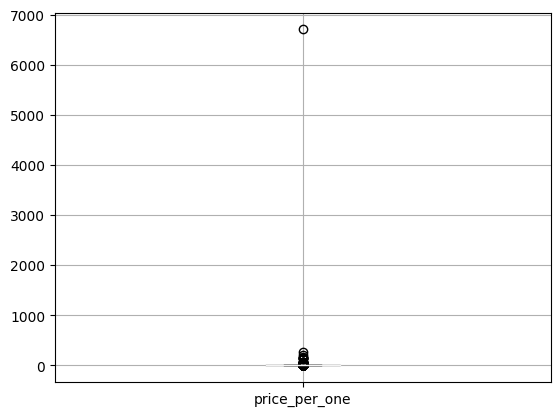

In [23]:
price.boxplot('price_per_one');

Магазин, очевидно, торгует мелочевкой. Судя по распределению 75% товара дешевле 5 рублей. В таком случае товар с стоимостью около 7 тысяч рублей вызывает подозрения.

In [24]:
price.query('price_per_one > 5000')

,item_id,price_per_one
3136,AMAZONFEE,6706.71


Какие-то сборы AMAZON. Посмотрим есть ли такой товар в основном датасете.

In [25]:
data.query('item_id == "AMAZONFEE"')

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
1181,C537652,AMAZONFEE,-2,2016-12-07 15:51:00,NaN,Shop 0,0.00
2637,C544589,AMAZONFEE,-2,2017-02-21 15:11:00,NaN,Shop 0,0.00
8119,C540117,AMAZONFEE,-2,2017-01-05 09:55:00,NaN,Shop 0,0.00
12550,537632,AMAZONFEE,0,2016-12-07 15:08:00,NaN,Shop 0,0.00
24571,C537630,AMAZONFEE,-2,2016-12-07 15:04:00,NaN,Shop 0,0.00
34815,C537651,AMAZONFEE,-2,2016-12-07 15:49:00,NaN,Shop 0,0.00
35911,C537644,AMAZONFEE,-2,2016-12-07 15:34:00,NaN,Shop 0,0.00
58981,C540118,AMAZONFEE,-2,2017-01-05 09:57:00,NaN,Shop 0,0.00
59911,C537647,AMAZONFEE,-2,2016-12-07 15:41:00,NaN,Shop 0,0.00
63101,C544587,AMAZONFEE,-2,2017-02-21 15:07:00,NaN,Shop 0,0.00


Все операции кем-то без карты постоянного покупателя. 

Возможно это закупка товара. В таком случае возникает вопрос к источнику наших данных: почему эта операция проводится через кассовый аппарат. (изначально нам дано, что данные "выгрузка с кассовых аппаратов")

Тем не менее эти данные могут испортить подсчет среднего чека. Удалим их как из data так и из price.

In [26]:
data = data.query('item_id != "AMAZONFEE"')
price = price.query('item_id != "AMAZONFEE"')

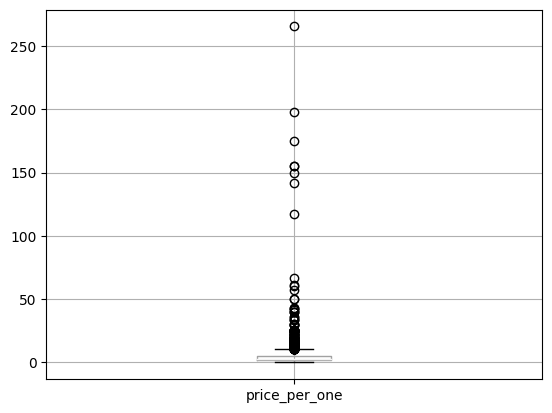

In [27]:
price.boxplot('price_per_one');

Теперь цены выглядят более однородно. Не будем считать, что цена в 250р для строительного магазина может быть странной.

### **data**

#### Тип данных

Изучим, и изменим если это необходимо, типы данных в таблице `data`

In [28]:
display(data.head())
data.info()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.00,Shop 0,0.00
1,538862,22195,0,2016-12-14 14:11:00,22389.00,Shop 0,1.00
2,538855,21239,7,2016-12-14 13:50:00,22182.00,Shop 0,1.00
3,543543,22271,0,2017-02-09 15:33:00,23522.00,Shop 0,1.00
4,543812,79321,0,2017-02-13 14:40:00,23151.00,Shop 0,1.00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 105324 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchase_id      105324 non-null  object 
 1   item_id          105324 non-null  object 
 2   quantity         105324 non-null  int64  
 3   purchase_date    105324 non-null  object 
 4   customer_id      69125 non-null   float64
 5   shop_id          105324 non-null  object 
 6   loyalty_program  105324 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.4+ MB


* loyalty_program - ожидаемый формат bool, а не float64, т.к. значения участие в программе лояльности 0 и 1
* purchase_date - ожидаемый тип данных datetime

Исправим типы:

In [29]:
data['loyalty_program'] = data['loyalty_program'].astype('bool')
data['purchase_date'] = pd.to_datetime(data['purchase_date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105324 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchase_id      105324 non-null  object        
 1   item_id          105324 non-null  object        
 2   quantity         105324 non-null  int64         
 3   purchase_date    105324 non-null  datetime64[ns]
 4   customer_id      69125 non-null   float64       
 5   shop_id          105324 non-null  object        
 6   loyalty_program  105324 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 5.7+ MB


* customer_id - ожидаемый формат int, а не float64, т.к. id пользователей это набор цифр.

Однако, так как колонка содержит пропуски, изменить формат не удастатся. Вернемся к этому столбцу при обработке пропусков. 

#### Пропуски

In [30]:
pass_check(data)

,cnt_of_pass,persent_of_pass
purchase_id,0,0%
item_id,0,0%
quantity,0,0%
purchase_date,0,0%
shop_id,0,0%
loyalty_program,0,0%
customer_id,36199,34%


In [31]:
pass_check(data.groupby('purchase_id').agg({'customer_id':'first'}).reset_index())

,cnt_of_pass,persent_of_pass
purchase_id,0,0%
customer_id,737,15%


Пропуски имеются только в столбце с id покупателей. Предположим что эти пропуски связаны с отсутсвием карты.

Проверим, нет ли пропусков в id у покупателей, с подключенной картой лояльности (тогда такие пропуски примем за ошибки в подгрузке данных и рассмотрим вариант об удалении таких строк)

In [32]:
data.query('loyalty_program == 1')['customer_id'].isna().sum()

0

Таким образом, исходя из информации заказчика можно сделать вывод о том, что пропуски в столбце с id покупателя соответсвуют покупкам без карты постоянного покупателя. 

Из анализа такие данные исключать явно не следует.

#### Дубликаты

In [33]:
duplicate_check(data)

Количество полных строк-дубликатов:  1033 

Процент дубликатов от всех данных:  0.98%


,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
5345,537265,21499,24,2016-12-06 11:26:00,21598.00,Shop 0,False
5863,540803,21485,0,2017-01-11 12:30:00,20348.00,Shop 0,False
6893,540524,21326,11,2017-01-09 12:53:00,22414.00,Shop 0,True
7821,537192,22585,0,2016-12-05 13:42:00,22081.00,Shop 0,True
10806,537772,22080,4,2016-12-08 12:35:00,23722.00,Shop 0,True
...,...,...,...,...,...,...,...
105164,542224,22178,5,2017-01-26 12:45:00,23567.00,Shop 0,True
105173,544153,82552,1,2017-02-16 12:11:00,21035.00,Shop 0,False
105178,540839,21123,0,2017-01-11 15:42:00,22470.00,Shop 0,True
105229,543277,21533,0,2017-02-06 14:33:00,21487.00,Shop 0,False


Так как процент дублирующих строк небольшой (чуть менее 1%) можно безболезненно удалить их.

In [34]:
data = data.drop_duplicates()
duplicate_check(data)

Количество полных строк-дубликатов:  0 

Процент дубликатов от всех данных:  0.00%


,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program


Посмотрим есть ли чеки, в которых одна и та же позиция пробита несколько раз. Рассмотрим совпадение по:
- id чека
- id товара
- дате покупки
- количеству товара в чеке

In [35]:
duplicate_check(data[['purchase_id', 'item_id', 'purchase_date', 'quantity']])

Количество полных строк-дубликатов:  0 

Процент дубликатов от всех данных:  0.00%


,purchase_id,item_id,purchase_date,quantity


Посмотрим, сколько дубликатов будет если не учитывать количество товара:

In [36]:
duplicate_check(data[['purchase_id', 'item_id', 'purchase_date']])

Количество полных строк-дубликатов:  939 

Процент дубликатов от всех данных:  0.90%


,purchase_id,item_id,purchase_date
1040,541838,84949,2017-01-23 10:43:00
4035,537781,20963,2016-12-08 12:46:00
4344,543713,82583,2017-02-11 11:46:00
5753,C538341,22726,2016-12-10 14:03:00
5983,541604,85049G,2017-01-19 17:23:00
...,...,...,...
105067,541843,20828,2017-01-23 12:08:00
105073,538843,22728,2016-12-14 13:18:00
105085,540647,22937,2017-01-10 14:57:00
105230,536863,22147,2016-12-03 11:19:00


Таким образом мы получили, что в одном чеке один товар может быть пробит несколько раз, но в разном количестве. **Интересная особенность работы кассового аппарата.**

#### Аномалии

Аномалии могут встречаться в количестве товара - столбец `quantity` основной таблицы

Изучим распределение значений:

In [37]:
data['quantity'].describe()

count   104291.00
mean         7.88
std        329.58
min     -74216.00
25%          0.00
50%          2.00
75%          7.00
max      74214.00
Name: quantity, dtype: float64

Очевидно в данных имеются аномальные значения. Визуализируем значения.

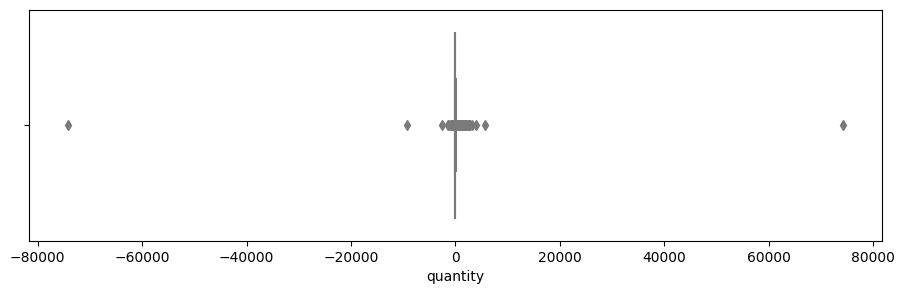

In [38]:
plt.figure(figsize=(11,3))
sns.boxplot(x=data['quantity']);

In [39]:
data.query('quantity == 74214 or quantity == -74216')

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
49411,C541433,23166,-74216,2017-01-18 10:17:00,18025.00,Shop 0,False
69074,541431,23166,74214,2017-01-18 10:01:00,18025.00,Shop 0,False


Отрицательные значения, предположительно, соответствуют возвращенным товарам. Так как магазин торгует строительными товарами, покупка 20, 30 или 100 позиций какого-либо товара не должна быть чем-то невозможным или невероятным. Однако единовременная покупка 74214, единиц товара уже вызывает подозрения, но так как затем произошел возврат этого товара - очевидна ошибка кассового аппарата или кассира. 

Отсюда же видно, что чек с возвратом, вероятно, носит пометку в id "С", предположительно от Canceled. 

Так как при подсчете суммы чека эти позиции самоустранятся - удалять их нету смысла. Однако при визуализации мы видим еще один выброс в отрицательных значениях. Отсутсвие симметричной покупки вызывает подозрения. Необходимо уточнить что это за позиция.

Найдем id покупателя, сделавшего большой возврат и посмотрим на все его покупки. Действительно ли ему было что возвращать?

In [40]:
data.loc[data['customer_id'] == data.query('quantity > -74216 and quantity < -5000 ').reset_index().at[0, 'customer_id']]

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
26789,537476,22379,149,2016-12-07 11:26:00,21517.00,Shop 0,False
39345,C536757,84347,-9361,2016-12-02 14:23:00,21517.00,Shop 0,False
45461,542921,22379,99,2017-02-02 07:58:00,21517.00,Shop 0,False
49812,537476,85099B,299,2016-12-07 11:26:00,21517.00,Shop 0,False
61442,537476,22381,99,2016-12-07 11:26:00,21517.00,Shop 0,False
97058,542921,22381,49,2017-02-02 07:58:00,21517.00,Shop 0,False


Получается, в изучаемый нами период покупатель не приобретал 9361 единиц товара. По данным видно, что это реальный покупатель с реальными товарами. 

Так как возврат совершен на второй день после начала сбора данных, возможно товар был приобретен как-раз перед началом программы лояльности. Удалим этот возврат из данных, что бы не испортить подсчет среднего чека большим отрицательным значением.

In [41]:
data = data.query('index != 39345')
data.loc[data['customer_id'] == 21517]

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
26789,537476,22379,149,2016-12-07 11:26:00,21517.00,Shop 0,False
45461,542921,22379,99,2017-02-02 07:58:00,21517.00,Shop 0,False
49812,537476,85099B,299,2016-12-07 11:26:00,21517.00,Shop 0,False
61442,537476,22381,99,2016-12-07 11:26:00,21517.00,Shop 0,False
97058,542921,22381,49,2017-02-02 07:58:00,21517.00,Shop 0,False


Остальные данные вполне подходят под нормальное количество товара.


#### Категоризация покупателей

Исходя из наличия пропусков в id покупателей распределим пользователей по трем группам:
- no card - покупатели без карты постоянного покупателя
- card - покупатели с картой постоянного покупателя
- loyalty_program - покупатели с картой постоянного покупателя и подключенной программой лояльности

In [42]:
data['card'] = (
    np.where(
        data['loyalty_program'] == 1, 
        'loyality program', 
        np.where(data['customer_id'].isna(), 'no card', 'card')))

#### Создание customer_id для покупателей без карты

Для нашего исследования будем считать, что покупатель без карты приходил в магазин один раз. 

Создадим для покупателей без карты свои id_customer. 1 чек = 1 покупатель. 

In [43]:
data['customer_id'].min()

18025.0

Так как минимальное значение `customer_id` - 18025, для покупателей без карты мы можем использовать нумерцию с нуля.

In [44]:
# Создаем таблицу со всеми уникальными чеками, выбираем айди покупателя для каждого чека
customer_with_pass = data.groupby('purchase_id').agg({'customer_id':'first'}).reset_index()

# Пронумеровываем покупателей без айди
a = 0
for i in range(customer_with_pass['customer_id'].shape[0]):
    if np.isnan(customer_with_pass.at[i, 'customer_id']):
        customer_with_pass.at[i, 'customer_id'] = a
        a += 1

# Создаем словарь чек:покупатель
dict_of_customer = customer_with_pass.set_index('purchase_id').T.to_dict('list')

# Заполняем покупателей по айди чека
data['customer_id'] = data.apply(lambda x: dict_of_customer.get(x['purchase_id'])[0], axis = 1 )

# меняем тип данных
data['customer_id'] = data['customer_id'].astype('int')

data

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,card
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,False,card
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,True,loyality program
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,True,loyality program
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,True,loyality program
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,True,loyality program
...,...,...,...,...,...,...,...,...
105330,538566,21826,1,2016-12-13 11:21:00,189,Shop 0,False,no card
105331,540247,21742,0,2017-01-05 15:56:00,21143,Shop 0,False,card
105332,538068,85048,1,2016-12-09 14:05:00,23657,Shop 0,True,loyality program
105333,538207,22818,11,2016-12-10 11:33:00,18427,Shop 0,False,card


### **Оплата программы лояльности**

Проверим, есть ли в наших данных товар, который имеет стоимость 200 (оплата карты лояльности)

In [45]:
price.query("price_per_one == 200")

,item_id,price_per_one


Получается, в наших данных не учитывается оплата карты лояльности. 

Так как по данным от заказчика оплата программы лояльности стоит 200р в месяц - "спишем" у участников карты лояльности 1 числа каждого месяца 200р. Добавим id_item "loyalty". 

In [46]:
price = price.append({"item_id":'loyalty',"price_per_one":200},ignore_index=True)

Будем счиать, что если у клиента не было покупки в каком-то месяце, то он не участвовал в программе. 

Создадим списки покупателей, по месяцам, соответсвенно этим спискам добавим покупателям "автоплатеж" за программу лояльности.

In [47]:
data['month'] = data['purchase_date'].astype('datetime64[M]')
# Количество заказов у пользователей по месяцам
customers_month = (data
                   .query('loyalty_program == 1')
                   .pivot_table(index='customer_id', columns='month', values='purchase_id', aggfunc='nunique')
                   )
customers_month.columns = customers_month.columns.astype('str')
customers_month = customers_month.rename(columns={'2016-12-01':'dec', '2017-01-01':'yan','2017-02-01':'feb'}).reset_index()
# Покупатели в каждом месяце с программой лояльности
customer_dec = customers_month[['customer_id', 'dec']].dropna()['customer_id'].unique()
customer_yan = customers_month[['customer_id', 'yan']].dropna()['customer_id'].unique()
customer_feb = customers_month[['customer_id', 'feb']].dropna()['customer_id'].unique()

In [48]:
# Создаем словарь с новыми строками для добавления в основную таблице
new_dict = []
loyalty = 0
for m in [customer_dec, customer_yan, customer_feb]:
    #print(m)
    if len(m) == len(customer_dec): # Используем разную дату "списания" в зависимости о того, совершал ли покупатель покупку в конкретном месяце
        time = dt.datetime(2016, 12, 1)
    elif len(m) == len(customer_yan):
        time = dt.datetime(2017, 1, 1)
    else:
        time = dt.datetime(2017, 2, 1)
                
    for i in m:
        new_dict.append({
            'purchase_id':'loyalty_'+str(loyalty), # создаем id чека
            'item_id':'loyalty', 
            'quantity':1, 
            'purchase_date':time, # вписываем дату "списания"
            'customer_id':i, # вставляем id покупателя
            'shop_id':'Shop 0', # допустим, списание происходило через основной магазин (см. далее по исследованию)
            'loyalty_program':1, 
            'card':'loyality program', 
            'month':time 
                        })
        loyalty += 1

In [49]:
# создаем новый датафрейм, меняем тип данных в нужных столбцах
df = pd.DataFrame(new_dict)
df['month'] = df['month'].astype('datetime64[M]')
df['purchase_date'] = pd.to_datetime(df['purchase_date'])

In [50]:
# добавляем созданный датафрейм с оплатой программы лояльности
data = pd.concat([data,df],ignore_index=True)
data

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,card,month
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,card,2016-12-01
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,1,loyality program,2016-12-01
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,1,loyality program,2016-12-01
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,1,loyality program,2017-02-01
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,1,loyality program,2017-02-01
...,...,...,...,...,...,...,...,...,...
105138,loyalty_848,loyalty,1,2017-02-01 00:00:00,23910,Shop 0,1,loyality program,2017-02-01
105139,loyalty_849,loyalty,1,2017-02-01 00:00:00,23924,Shop 0,1,loyality program,2017-02-01
105140,loyalty_850,loyalty,1,2017-02-01 00:00:00,23929,Shop 0,1,loyality program,2017-02-01
105141,loyalty_851,loyalty,1,2017-02-01 00:00:00,23936,Shop 0,1,loyality program,2017-02-01


Теперь в наших данных присутсвует чек с оплатой программы лояльности.

### **Добавление новых столбцов**

Для дальнейшего анализа и работы с данными добавим к исходной таблице цену за единицу товара по каждой позиции, сумму за указанное количество товара. Так же добавим столбец с неделей совершения покупки.

In [51]:
data['week'] = data['purchase_date'].astype('datetime64[W]')
data = data.merge(price, how='left', on='item_id')
data['total_sum'] = data['quantity'] * data['price_per_one']
data

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,card,month,week,price_per_one,total_sum
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,card,2016-12-01,2016-12-08,1.63,17.93
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,1,loyality program,2016-12-01,2016-12-08,3.29,0.00
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,1,loyality program,2016-12-01,2016-12-08,1.63,11.41
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,1,loyality program,2017-02-01,2017-02-09,4.37,0.00
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,1,loyality program,2017-02-01,2017-02-09,5.75,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
105138,loyalty_848,loyalty,1,2017-02-01 00:00:00,23910,Shop 0,1,loyality program,2017-02-01,2017-01-26,200.00,200.00
105139,loyalty_849,loyalty,1,2017-02-01 00:00:00,23924,Shop 0,1,loyality program,2017-02-01,2017-01-26,200.00,200.00
105140,loyalty_850,loyalty,1,2017-02-01 00:00:00,23929,Shop 0,1,loyality program,2017-02-01,2017-01-26,200.00,200.00
105141,loyalty_851,loyalty,1,2017-02-01 00:00:00,23936,Shop 0,1,loyality program,2017-02-01,2017-01-26,200.00,200.00


### **Вывод**
В процессе предобработки были обнаружены следующие особенности данных:
- Данные собраны не очень качественно, не хватает данных об оплате программы лояльности.
- В данных встречается нулевое количества товара, непонятно откуда берутся эти позиции.
- По данным в одном чеке одна и та же позиция может быть пробита несколько раз в разном количестве.
- Ко многим позициям из прайса в данных дано несколько цен, и нет никаких маркировок для какого заказа какую цену применять.
- Айди товаров наводят на мысли о том, что данные собраны не только с кассовых аппаратов.

Данные собраны не очень качественно. 
В качестве рекомендации для последующего сбора данных хотелось бы предложить следующие моменты:
- Учитывать оплату программы лояльности
- Указывать чем отличаются цены в прайсе или, как вариант, записывать итоговую стоимость каждой позиции в чеке.
- Внимательнее отнестись к источнику данных. Откуда мы получаем данные? с кассовых аппаратов или все же это общие данные о движении средств в магазинах?

## **Анализ данных**

### **Анализ количества товаров**

#### Нулевое количество

Нулевое количество товаров, конечно, не повлияет на выводы относительно эффективности программы лояльности, т.к. мы будем рассматривать величину среднего чека. 

Но, так как в дальнейшем планируется произвести анализ количества позиций в каждом чеке, изучим, как удаление нулевых позиций повлияет на наши данные:

In [52]:
print('Количество чеков с нулевыми позициями: ', 
      data['purchase_id'].nunique())
print('Количество чеков без нулевых позиций: ', 
      data.query('quantity != 0')['purchase_id'].nunique())
print('Процент чеков, которые будут утеряны при удалении нулевых позиций: ', 
      '{:.2%}'.format(1 - data.query('quantity != 0')['purchase_id'].nunique() / data['purchase_id'].nunique()))
print('\nКоличество покупателей с нулевыми позициями: ',
      data['customer_id'].nunique())
print('Количество покупателей без нулевых позиций: ', 
      data.query('quantity != 0')['customer_id'].nunique())
print('Процент покупателей, которые будут утеряны при удалении нулевых позиций: ', 
      '{:.2%}'.format(1 - data.query('quantity != 0')['customer_id'].nunique() / data['customer_id'].nunique()))
print('\nПроцент всех данных, которые будут утеряны при удалении нулевых позиций: ', 
      '{:.2%}'.format(1 - data.query('quantity != 0').shape[0] / data.shape[0]))

Количество чеков с нулевыми позициями:  5735
Количество чеков без нулевых позиций:  5571
Процент чеков, которые будут утеряны при удалении нулевых позиций:  2.86%

Количество покупателей с нулевыми позициями:  2486
Количество покупателей без нулевых позиций:  2372
Процент покупателей, которые будут утеряны при удалении нулевых позиций:  4.59%

Процент всех данных, которые будут утеряны при удалении нулевых позиций:  30.78%


Нулевые позиции в чеке носят неизвестный характер. Для анализа эффективности программы лояльности они не несут никакой пользы, поэтому, несмотря на высокий процент потери данных (30%) их можно удалить. Потеря уникальных чеков и покупателей, которые в целом то и не принесли никакого дохода магазину можно считать небольшой. 

Удаляем позиции, в которых количество товара = 0.

In [53]:
data = data.query('quantity != 0')

#### Отрицательное количество

При изучении данных было обнаружено, что количество товаров в чеке не всегда имеет положительные значения. Встречаются значения равные нулю и отрицательные. Можно предположить, что отрицательные значения - это возврат товаров. Однако ранее обнаруженные аномалии в виде товара с id_item AMAZONFEE наталкивают на мысль что отрицательные значения это не только возвраты. Так как у нас нет четкого понимания что обозначают айди товаров можно предположить, что кроме физических товаров под айди могут находится и какие-либо финансовые операции, комиссии, опалата ком.услуг и прочее.

Изучим данные более детально. Вычислим id товаров с отрицательным количеством, для которых отсутствует предварительная покупка этого товара. 

Создадим таблицу, соержащую товары, которые возвращались

In [54]:
item_quantity_minus = data.query('quantity < 0')['item_id'].unique() #список товаров, которые имеют отрицательное количество
item_quantity_plus = data.query('quantity >= 0')['item_id'].unique() #список товаров, которые имеют положительное количество
no_item = list(set(item_quantity_minus) - set(item_quantity_plus)) #Список товаров, у которых было ТОЛЬКО отрицательное значение
data.query('item_id in @no_item')

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,card,month,week,price_per_one,total_sum
1513,C544575,BANK CHARGES,-2,2017-02-21 13:58:00,730,Shop 0,0,no card,2017-02-01,2017-02-16,141.96,-283.92
2976,C544580,S,-2,2017-02-21 14:25:00,732,Shop 0,0,no card,2017-02-01,2017-02-16,12.95,-25.90
3319,C536548,20957,-2,2016-12-01 14:33:00,18151,Shop 4,0,card,2016-12-01,2016-12-01,1.45,-2.90
3653,C537232,84840,-3,2016-12-06 09:31:00,18265,Shop 11,0,card,2016-12-01,2016-12-01,8.50,-25.50
4537,C537581,S,-2,2016-12-07 12:03:00,705,Shop 0,0,no card,2016-12-01,2016-12-01,12.95,-25.90
...,...,...,...,...,...,...,...,...,...,...,...,...
101655,542560,47579,-2,2017-01-28 14:51:00,500,Shop 0,0,no card,2017-01-01,2017-01-26,1.05,-2.10
101861,542552,21645,-2,2017-01-28 14:47:00,492,Shop 0,0,no card,2017-01-01,2017-01-26,0.82,-1.65
101884,540560,21589,-15,2017-01-10 10:08:00,340,Shop 0,0,no card,2017-01-01,2017-01-05,0.00,-0.00
103656,C544576,BANK CHARGES,-2,2017-02-21 14:01:00,731,Shop 0,0,no card,2017-02-01,2017-02-16,141.96,-283.92


Действительно, среди операций встретилось название id_item BANK CHARGES - комиссия банка.

Будем считать что обнаруженные отрицательные значения - это либо комисси за различные операции либо ошибочные данные, когда операция учлась как возврат товара.

Удалим товары, которые встречаются только с отрицательным количеством. Таким образом мы уменьшим искажение полученных в ходе анализа данных.

In [55]:
data = data.query('item_id not in @no_item')

In [56]:
data

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,card,month,week,price_per_one,total_sum
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,card,2016-12-01,2016-12-08,1.63,17.93
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,1,loyality program,2016-12-01,2016-12-08,1.63,11.41
7,541424,79321,1,2017-01-17 17:57:00,392,Shop 0,0,no card,2017-01-01,2017-01-12,5.75,5.75
10,537795,82494L,5,2016-12-08 13:03:00,22892,Shop 0,1,loyality program,2016-12-01,2016-12-08,5.21,26.02
11,541696,22197,4,2017-01-20 18:08:00,415,Shop 0,0,no card,2017-01-01,2017-01-19,1.24,4.96
...,...,...,...,...,...,...,...,...,...,...,...,...
105138,loyalty_848,loyalty,1,2017-02-01 00:00:00,23910,Shop 0,1,loyality program,2017-02-01,2017-01-26,200.00,200.00
105139,loyalty_849,loyalty,1,2017-02-01 00:00:00,23924,Shop 0,1,loyality program,2017-02-01,2017-01-26,200.00,200.00
105140,loyalty_850,loyalty,1,2017-02-01 00:00:00,23929,Shop 0,1,loyality program,2017-02-01,2017-01-26,200.00,200.00
105141,loyalty_851,loyalty,1,2017-02-01 00:00:00,23936,Shop 0,1,loyality program,2017-02-01,2017-01-26,200.00,200.00


#### Возвраты

Что бы получить возвраты, нам нужно получить только те id товаров, которые имеют и положительное и отрицательное количество у одного покупателя. Списки из предыущего пункта не подойдут, т.к. там не учитывается, что возврат осуществляет тот же покупатель.


In [57]:
# Собираем таблицу с товарами, которые подвергались и покупке и возврату одним и тем же покупателем
refund = (data
          .query('item_id != "loyalty"') # исключаем программу лояльности
          .loc[data[['item_id', 'customer_id']] # находим дубликаты покупатель+товар
               .duplicated(keep=False)] # выбираем все дублирующиеся строки
          [['item_id','customer_id', 'purchase_id','quantity','purchase_date']] # Все столбцы нам не нужны
          .reset_index() # сохраняем исходные индексы
         )

Соберем горизонтально таблицу покупка / возврат
Добавим столбец, в котором будет указано в течении какого времени произошел возврат

In [58]:
refund_merge = (refund.query('quantity > 0') # ко всем товарам с положительным количеством
                .merge(refund.query('quantity < 0')[
                    ['customer_id', 'item_id', 'purchase_id', 'purchase_date', 'quantity', 'index']
                                                    ], # добавляем товар с отрицательным количеством
                       on = ['item_id', 'customer_id'], # по пересечению товара и покупателя
                       how='inner', # отсеиваем покупки без возврата (возврат без покупок отсеян ранее)
                       suffixes=('_pl', '_min'))
            )
refund_merge['diff_date']= refund_merge['purchase_date_min'] - refund_merge['purchase_date_pl']
refund_merge.head()
# Сюда же попали товары, которые были возвращены дважды или трижды

,index_pl,item_id,customer_id,purchase_id_pl,quantity_pl,purchase_date_pl,purchase_id_min,purchase_date_min,quantity_min,index_min,diff_date
0,47,22470,21840,537238,2,2016-12-06 10:03:00,C538684,2016-12-14 09:26:00,-2,57564,7 days 23:23:00
1,47,22470,21840,537238,2,2016-12-06 10:03:00,C543643,2017-02-10 17:44:00,-3,83740,66 days 07:41:00
2,53,22936,19835,541220,71,2017-01-14 14:11:00,C545033,2017-02-25 16:26:00,-73,11474,42 days 02:15:00
3,146,22841,20020,542111,1,2017-01-25 13:55:00,C542257,2017-01-26 17:06:00,-3,96122,1 days 03:11:00
4,190,22634,18106,536861,7,2016-12-03 10:44:00,C539866,2016-12-23 10:20:00,-5,87622,19 days 23:36:00


In [59]:
refund_merge['diff_date']= refund_merge['purchase_date_min'] - refund_merge['purchase_date_pl']
refund_merge.head()

,index_pl,item_id,customer_id,purchase_id_pl,quantity_pl,purchase_date_pl,purchase_id_min,purchase_date_min,quantity_min,index_min,diff_date
0,47,22470,21840,537238,2,2016-12-06 10:03:00,C538684,2016-12-14 09:26:00,-2,57564,7 days 23:23:00
1,47,22470,21840,537238,2,2016-12-06 10:03:00,C543643,2017-02-10 17:44:00,-3,83740,66 days 07:41:00
2,53,22936,19835,541220,71,2017-01-14 14:11:00,C545033,2017-02-25 16:26:00,-73,11474,42 days 02:15:00
3,146,22841,20020,542111,1,2017-01-25 13:55:00,C542257,2017-01-26 17:06:00,-3,96122,1 days 03:11:00
4,190,22634,18106,536861,7,2016-12-03 10:44:00,C539866,2016-12-23 10:20:00,-5,87622,19 days 23:36:00


Посмотрим, какие товары действительно были возвращены, как мы знаем возврат можно осуществить в течении 14 дней, так же исключим те случаи, когда товара возвращено больше чем куплено

In [60]:
real_refund = refund_merge.query('diff_date > "0 days" and diff_date < "14 days" and quantity_pl >= abs(quantity_min)')
real_refund.head()

,index_pl,item_id,customer_id,purchase_id_pl,quantity_pl,purchase_date_pl,purchase_id_min,purchase_date_min,quantity_min,index_min,diff_date
0,47,22470,21840,537238,2,2016-12-06 10:03:00,C538684,2016-12-14 09:26:00,-2,57564,7 days 23:23:00
26,430,22907,20873,540413,11,2017-01-07 10:29:00,C540786,2017-01-11 11:42:00,-8,80997,4 days 01:13:00
31,962,22963,20344,542923,11,2017-02-02 09:08:00,C543606,2017-02-10 14:13:00,-2,69183,8 days 05:05:00
34,34623,22358,22349,540697,5,2017-01-11 09:20:00,C541235,2017-01-14 17:13:00,-3,31345,3 days 07:53:00
42,67056,21314,19446,536395,7,2016-12-01 10:47:00,C536758,2016-12-02 14:25:00,-2,31284,1 days 03:38:00


Получили почти 500 возвратов. Возможно, какие-то из отсеянных нами возвратов были ошибочно посчитаны, но проверять все возможные варианты нецелесообразно. Оставим в датасете только те возвраты, которые не содержат ошибок. Для этого выберем индексы строк возвратов, не вошедших в таблицу с настоящими возвратами и уберем их из основного датасета.

In [61]:
drop_refund = (refund_merge
               .query('diff_date < "0 days" or diff_date > "14 days" and quantity_pl < abs(quantity_min)')
               ['index_min']
               .to_list()
              )

In [62]:
data = data.query('index not in @drop_refund')

Проверим наше предположение о том, что чеки с возвратом содержат в своем id букву С:

In [63]:
print('Число чеков в списке: ', real_refund.shape[0])
print('Число чеков в списке, содержащих "С" в id:', real_refund['purchase_id_pl'].str.contains('C').count())

Число чеков в списке:  498
Число чеков в списке, содержащих "С" в id: 498


Действительно, количество чеков совпадает с количеством чеков, содержащих С в id

#### Вывод
В данных обнаружены нулевые и отрицательные позиции. 

Товары, с отрицательным количеством чатично удалены на стадии предобработки, там мы удалили товары, которые во всем атасете имели только отрицательные значения: это либо возвраты за более ранний период, либо операции, не относящиеся к покупателям.

Частично мы удалили такие товары, которые не подходят под категорию возврат: дата после покупки более двух недель или товара возвращено больше, чем предварительно куплено.

Данные с нулевым количеством товара мы удалили, так как сочли их неинформативными для нашего исследования.

### **Анализ количества покупателей**

Исследуем количество покупателей в сети магазинов с разных сторон. Ответим на вопросы:
- Сколько всего покупателей посещало магазины
- Как покупатели распределяются по группам
- Сколько покупателей совершают покупки каждую неделю
- Сколько покупателей бывает в каждом магазине

#### Общее число покупателей

In [64]:
print('Общее количество покупателей: ', data['customer_id'].nunique())
print('Покупатели с картой постоянного покупателя: ', data.query('card !="no card"')['customer_id'].nunique())

Общее количество покупателей:  2309
Покупатели с картой постоянного покупателя:  1742


#### Распределение покупателей по группам

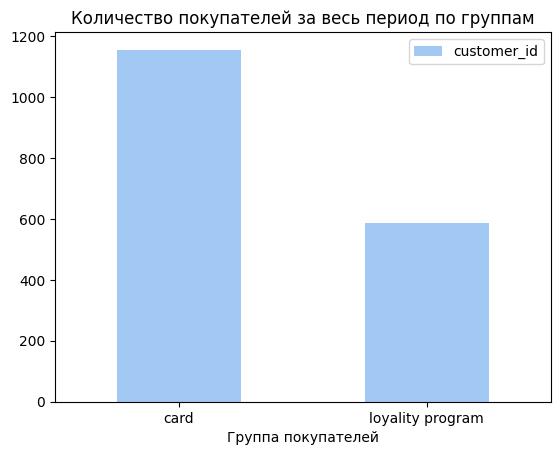

In [65]:
customers_group = (data.query('card != "no card"').pivot_table(index='card', values='customer_id', aggfunc='nunique'))
customers_group.plot(kind='bar', y='customer_id', rot = 0)
plt.xlabel('Группа покупателей')
plt.title('Количество покупателей за весь период по группам');

In [66]:
customers_group

,customer_id
card,
card,1155
loyality program,587


Самое большое количество покупателей приходят в магазин имея карту лояльности.

Так как покупатели с подключенной картой лояльности имеют саму эту карту, мы можем подсчитать процент покупателей, у которых, при наличии карты, подключена программа:

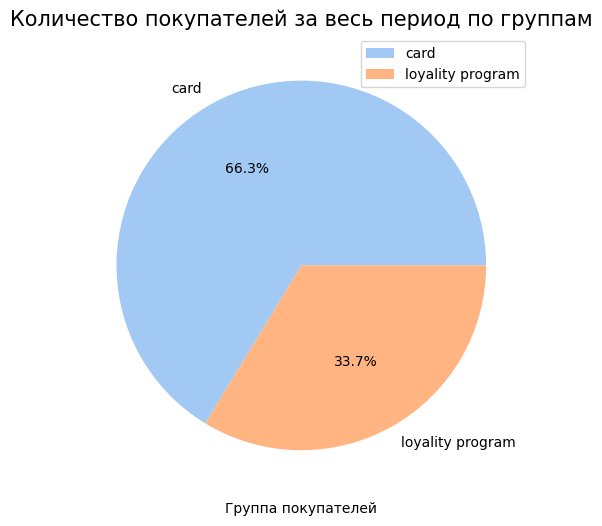

In [96]:

dd = data.query('card !="no card"').pivot_table(index='card', values='customer_id', aggfunc='nunique')
dd.plot(kind='pie', y='customer_id', x='card', autopct='%1.1f%%', figsize=(6,6))

plt.ylabel('')
plt.xlabel('Группа покупателей')
plt.title('Количество покупателей за весь период по группам', fontsize=15);

Треть покупателей имеющих карту постоянного покупателя подключили себе программу лояльности.

#### Распределение покупателей по неделям

Посмотрим как распределяется количество уникальных покупателей по неделям (если покупатель зашел в магазин за неделю несколько раз, то для строительного магазина вероятнее всего это возврат)

Для "чистоты эксперимента" уберем из анализируемых данных списание за программу лояльности.

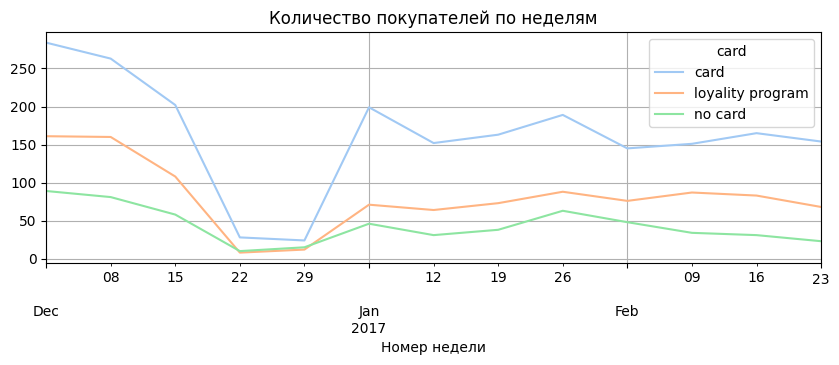

In [68]:
customers_week = (data.query('item_id != "loyalty"')
                  .pivot_table(index='week', columns='card', values='customer_id', aggfunc='nunique')
                 )
customers_week.plot(grid=True, figsize=(10,3))
plt.xlabel('Номер недели')
plt.title('Количество покупателей по неделям');

Количество покупателей по группам увеличивается и уменьшается равномерно/ соразмерно. Никакого повышенного и отличного от других покупателей ажиотажа со стороны покупателей с картой лояльности отмечено не было.

Возможно количество индивидуальных уведомлений о подарках и скидках недостаточно, что бы привлечь повышенное число покупателей в магазин.

В строительном магазине в предпраздничные дни был провал по продажам. Однако в первую же неделю траффик восстанваливается. В целом чаще всего покупателями были обладатели карты постоянного покупателя, но, их в наших данных и больше.

#### Распределение покупателей по магазинам
Посмотрим какие магазины сети чаще посещали наши покупатели:

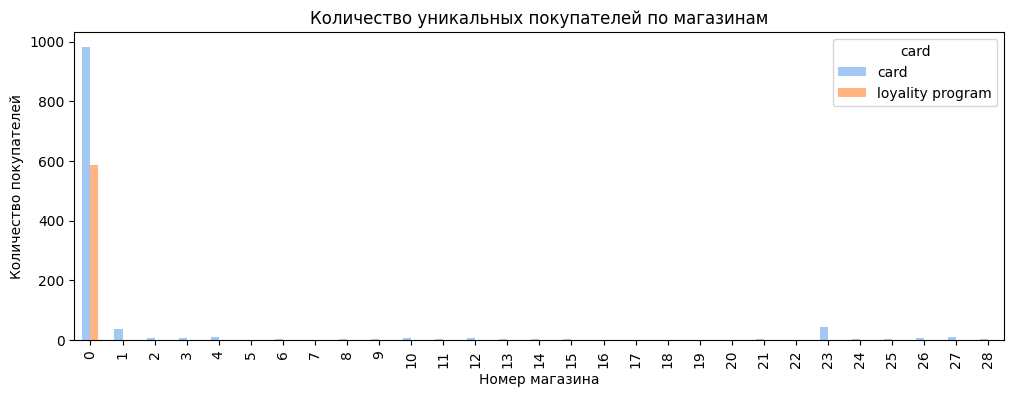

In [69]:
(data.query('card != "no card"')
 .pivot_table(index='shop_id', columns='card', values='customer_id', aggfunc='nunique').reset_index()
 .plot(figsize=(12,4), kind='bar', )
)
plt.ylabel('Количество покупателей')
plt.xlabel('Номер магазина')
plt.title('Количество уникальных покупателей по магазинам')
plt.show()

Интересное распределение. Существенное количество продаж было только в магазине с идентификатором 0.

Изучим в каких магазинах были отмечены покупатели с подключенной программой лояльности:

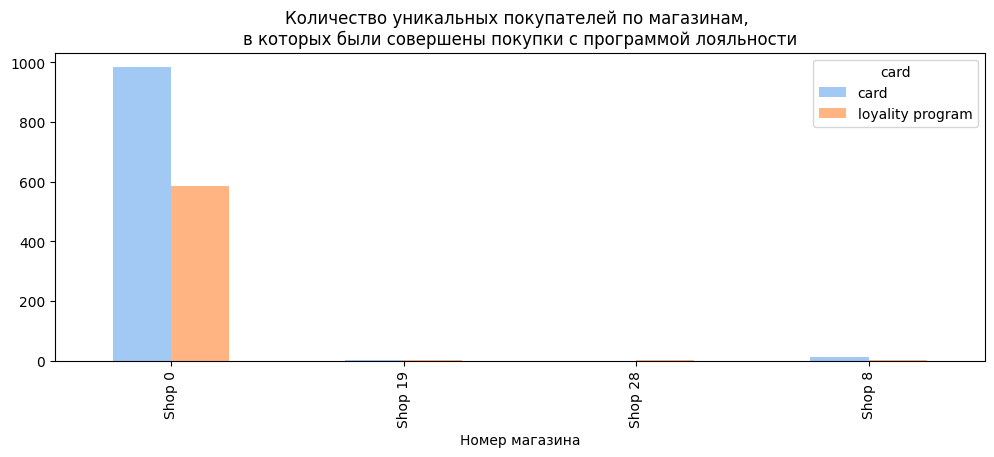

card,card,loyality program
shop_id,,
Shop 0,983.00,587.00
Shop 19,2.00,1.00
Shop 28,NaN,1.00
Shop 8,11.00,1.00


In [70]:
shop_with_loyalty = data.query('card != "no card"').query('loyalty_program == 1')['shop_id'].unique()
customer_on_shop_with_loyalty = (data.query('card != "no card"')
                                 .query('shop_id in @shop_with_loyalty')
                                 .pivot_table(index='shop_id', columns='card',
                                              values='customer_id', aggfunc='nunique')
                                )
customer_on_shop_with_loyalty.plot(figsize=(12,4), kind='bar')
plt.xlabel('Номер магазина')
plt.title('Количество уникальных покупателей по магазинам, \nв которых были совершены покупки с программой лояльности')
plt.show()
customer_on_shop_with_loyalty

Таким образом, помимо малого количества данных из магазинов, отличных от магазина с идентификатором 0, так же в них мало покупателей с поключенной программой лояльности. Это может указывать либо на то, что программа лояльности действует не во всех магазинах, либо просто из-за малого количества покупателей в этих точках туда не попали покупатели с подключенной программой.

#### Вывод
* Мы имеем данные о 2 327 покупателях. 
* 1 743 имеют карту постоянного покупателя.
* Треть покупателей с картой подключили программу лояльности.
* Самое большое число покупателей было в начале изучаемого периода
* Активность покупателей перед Новым годом снизилась
* Каждую неделю покупатели разных категорий приходят в магазин равномерно, без всплеска посещаемости какой либо категорией
* Самое большое количество покупателей было в магазине Shop 0 - несопоставимое с количеством покупателей в других точках.

### **Анализ количества покупок (чеков)**
#### Количество покупок за весь период
Так как покупатели с программой лояльности приобретали подписку, в эти данные так же будут включены покупки программы лояльности. 

Напомним, что мы добавили оплату программы 1 раз в месяц в том случае, если покупатель с подключенной программой в этом месяце что либо покупал в магазине.

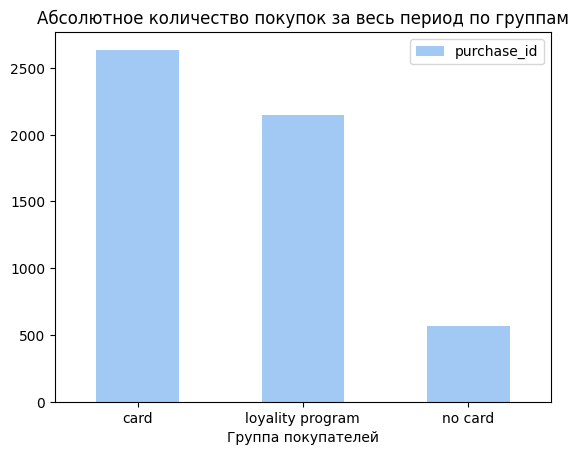

In [71]:
purchase_of_customers_group = (data.pivot_table(index='card', values='purchase_id', aggfunc='nunique'))

purchase_of_customers_group.plot(kind='bar', y='purchase_id', rot = 0)
plt.xlabel('Группа покупателей')
plt.title('Абсолютное количество покупок за весь период по группам');

В целом покупатели с картой постоянного покупателя совершили больше покупок в магазинах. Посмотрим сколько в среднем совершил каждый покупатель покупок в магазинах с разбивкой по группам:

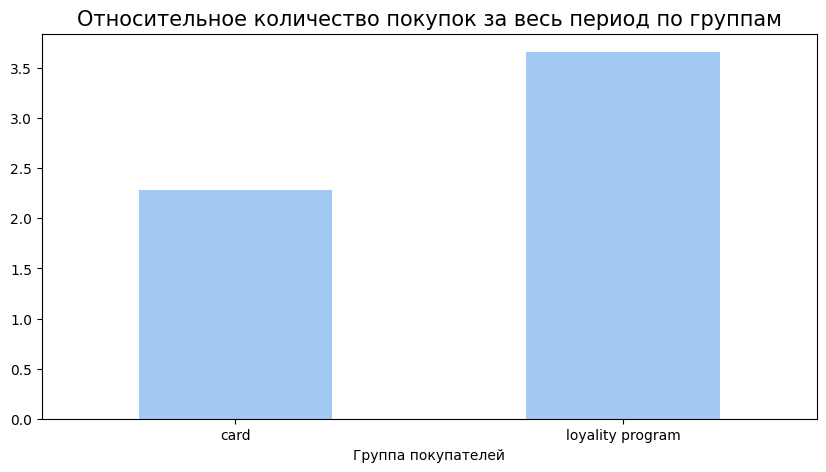

In [72]:
purchase_of_customers_group = (data.query('card != "no card"').pivot_table(index='card', values='purchase_id', aggfunc='nunique'))

((purchase_of_customers_group.rename(columns={'purchase_id':'ratio'}) / 
 customers_group.rename(columns={'customer_id':'ratio'}))
 .plot(kind='bar', y='ratio', rot = 0, figsize=(10,5), legend=False)
)

plt.xlabel('Группа покупателей')
plt.title('Относительное количество покупок за весь период по группам', fontsize=15);

Несмотря на общее бОльшее количество покупок у обладателей карты постоянного покупателя, покупатели с подключенной программой лояльности в среднем совершали больше походов в магазин.

#### Распределение покупок (чеков) по неделям

Изучим как распределены покупки по неделям. Из данных исключим оплату программы лояльности. В противном случае мы получим всплески в первую неделю каждого месяца у подключивших карту лояльности.

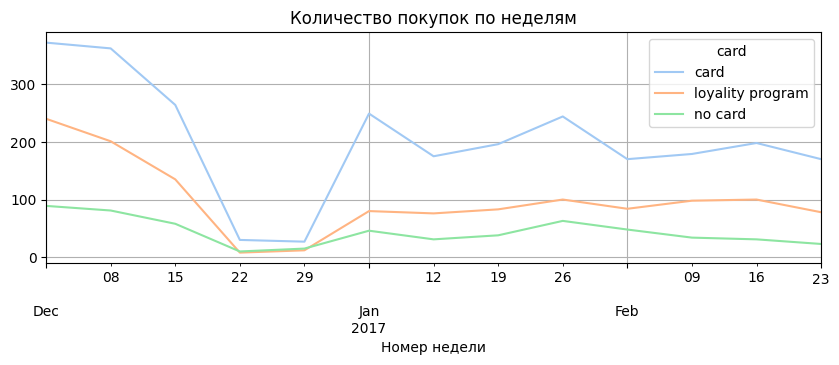

In [73]:
(data.query('item_id != "loyalty"')
 .pivot_table(index='week', columns='card', values='purchase_id', aggfunc='nunique')
 .plot(grid=True, figsize=(10,3))
)

plt.xlabel('Номер недели')
plt.title('Количество покупок по неделям')
plt.show()


Выделяющихся участков нет, количество покупок увеличивалось и уменьшалось по неделям одинаково у всех групп покупателей.

#### Распределение покупок по магазинам

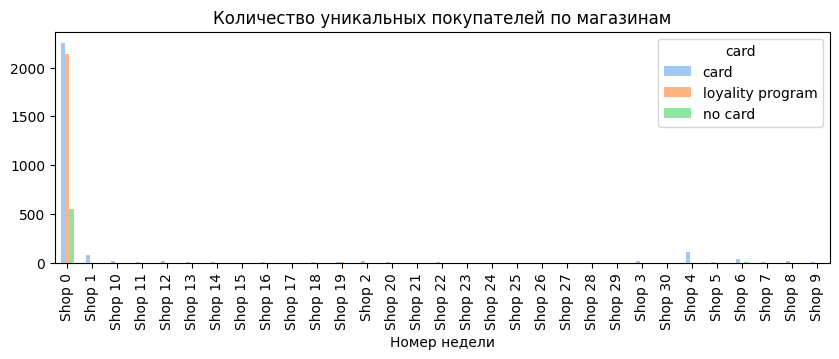

In [74]:
(data
 .pivot_table(index='shop_id', columns='card', values='purchase_id', aggfunc='nunique')
 .plot(figsize=(10,3), kind='bar')
)
plt.xlabel('Номер недели')
plt.title('Количество уникальных покупателей по магазинам')
plt.show()

#### Вывод
* Наибольшее количество покупок на покупателя совершили покупатели с подключенной программой лояльности
* Самый посещаемый магазин - магазин с идентификатором 0.

### **Анализ количества товара в чеке**

#### Среднее количество видов и единиц товара в чеке
Изучим среднее количесвтво различных товаров в каждом чеке. 

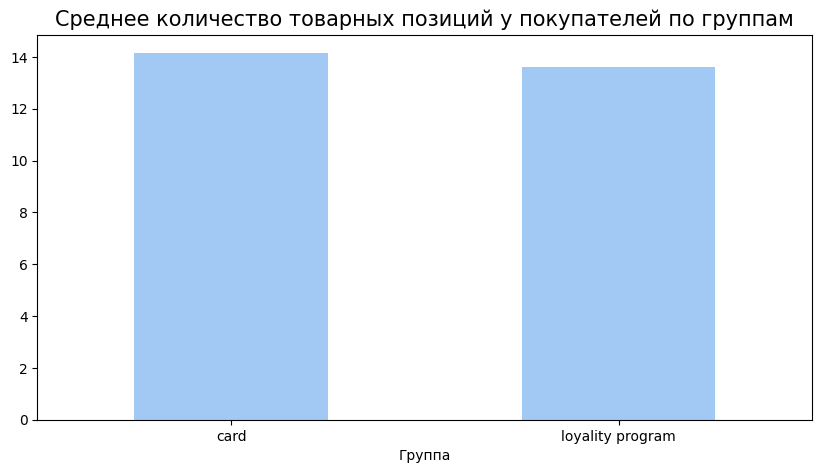

In [75]:
(data.query('card != "no card"')
 .query('item_id != "loyalty"')
 .pivot_table(index=['card', 'purchase_id'], values='item_id', aggfunc='nunique')
 .groupby('card').agg({'item_id':'mean'})
 .plot(kind='bar', y='item_id', rot = 0, figsize=(10,5), legend=False)
)
plt.xlabel('Группа')
plt.title('Среднее количество товарных позиций у покупателей по группам', fontsize=15);

Покупатели, не имеющие карту постоянного покупателя кладут в свою корзину больше разнообразного товара. Закупают для ремонта одним махом все расходные материалы?

Посмотрим как обстоит дело с количеством единиц товара каждого вида:

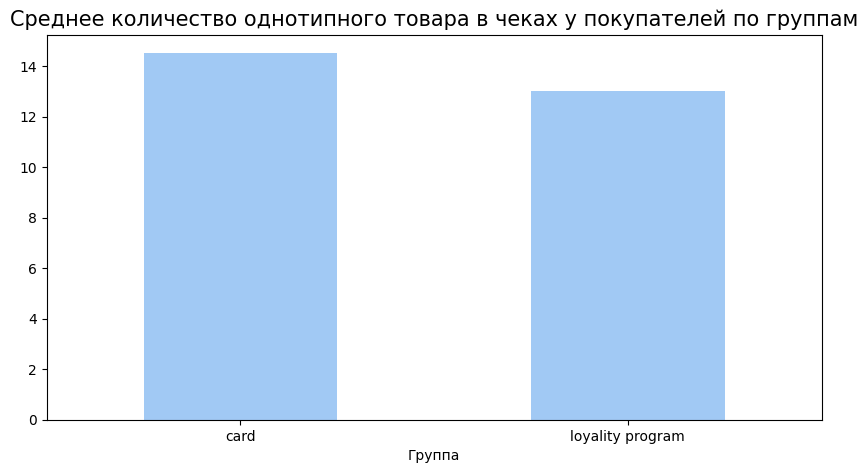

In [76]:
(data.query('item_id != "loyalty"').query('card != "no card"')
.pivot_table(index='card', values='quantity', aggfunc='mean')
.plot(kind='bar', y='quantity', rot = 0, figsize=(10,5), legend=False))
plt.xlabel('Группа')
plt.title('Среднее количество однотипного товара в чеках у покупателей по группам', fontsize=15);

Покупатели с картой, покупают больше единиц товара за одну покупку, чем покупатели без карты. Возможно эти покупатели чаще приходят за мелким товаром, который продается в больших количествах, например гвозди или шурупы. 

Покупатели без карты видимо чаще покупают товары, которые не нужны в большом количестве, например молотки или топоры.

Покупатели с подключенной программой лояльности покупают чуть меньше штук товара за раз, чем без нее.

Таким образом покупатели с картой и программой покупают примерно равное количество разнообразного товара примерно в одинаковом количестве, а вот покупатели без карты покупают много разнообразного товара, но каждый товар малым объемом.

#### Среднее количество видов и единиц товара в чеке по неделям

Посмотрим отличается ли количество разного товара (молотки, гвозди, шурупы) в чеке по неделям:

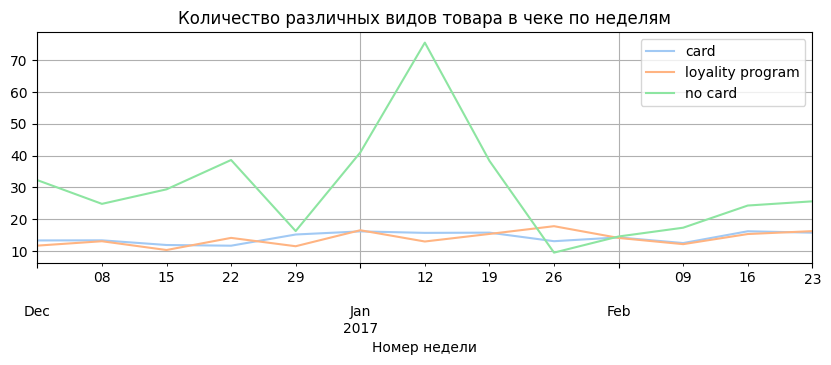

In [77]:
(data
 .query('item_id != "loyalty"')
 .pivot_table(index=['week', 'purchase_id'], columns='card', values='item_id', aggfunc='nunique').reset_index()
 .groupby('week').agg({'card':'mean', 'loyality program':'mean', 'no card':'mean', })
 .plot(grid=True, figsize=(10,3))
)

plt.xlabel('Номер недели')
plt.title('Количество различных видов товара в чеке по неделям')
plt.show()

Массовая закупка всего и сразу покупателями без карт была в начале января. Покупатели с картой постоянного покупателя с программой и без нее в течении всего периода покупали примерно одинаковое количество товаров.

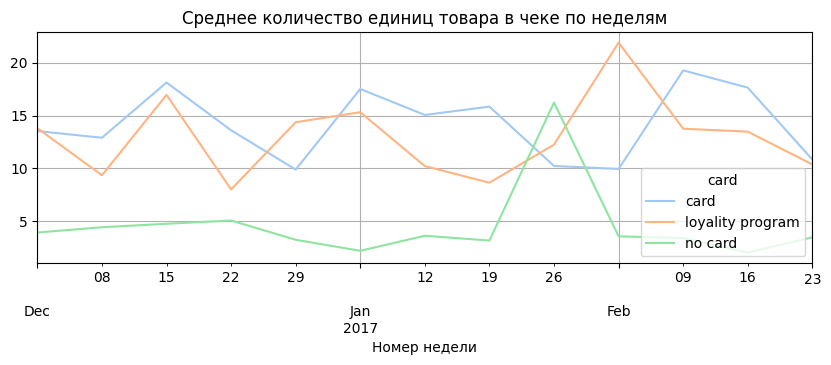

In [78]:
(data.query('item_id != "loyalty"')
 .pivot_table(index='week', columns='card', values='quantity', aggfunc='mean')
 .plot(grid=True, figsize=(10,3))
)

plt.xlabel('Номер недели')
plt.title('Среднее количество единиц товара в чеке по неделям')
plt.show()

Уже не первый раз сталкиваемся с повышенным интересом к магазину у покупателей без карт в конце января. Видимо была массовая закупка мелким штучным товаром. 

Так же наблюдается "вспышка" интереса в первую неделю февраля у покупателей с подключенной картой лояльности. Покупатели в этот период добавляют в свою корзину больше единиц каждого товара. Возможно были акции на мелкий поштучный товар, на те же гвозди, например.

#### Среднее количество товара в чеке по магазинам

Посмотрим как распределяется сренее количество различного товара по магазинам:

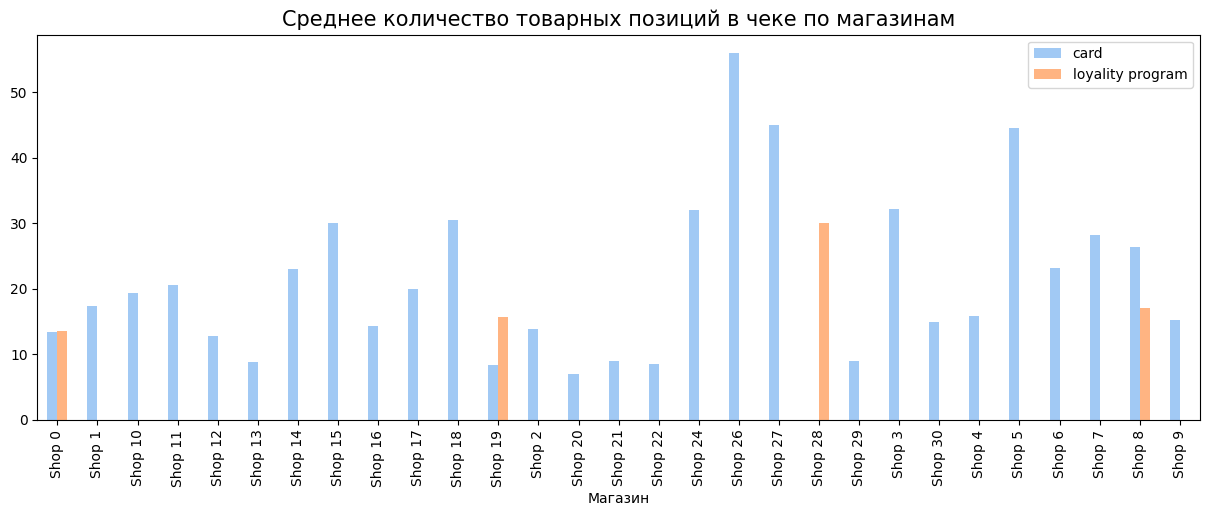

In [79]:
(data
 .query('item_id != "loyalty"').query('card != "no card"')
 .pivot_table(index=['shop_id','purchase_id'], columns='card', values='item_id', aggfunc='nunique').reset_index()
 .groupby('shop_id').agg({'card':'mean', 'loyality program':'mean', 
                          #'no card':'mean',
                         })
 .plot(kind='bar', figsize=(15,5),)
)
plt.xlabel('Магазин')
plt.title('Среднее количество товарных позиций в чеке по магазинам', fontsize=15)
plt.show()

Несмотря на самую высокую посещаемость Shop 0 продает он однообразный товар. Во многих других магазинах покупатели предпочитают складывать в свою корзину больше различного товара.

И среднее количество этих товаров:

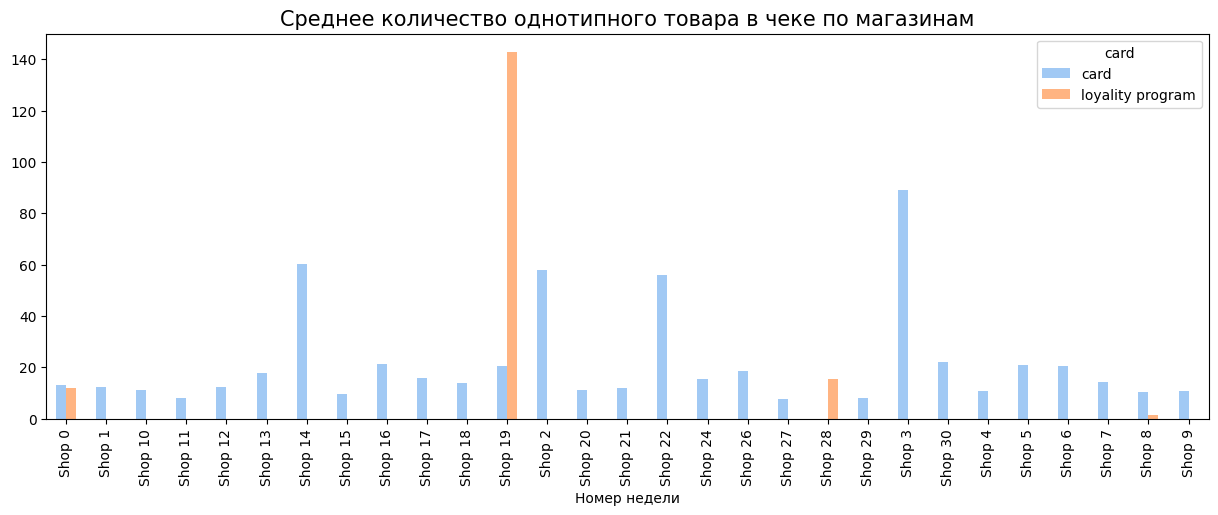

In [80]:
(data.query('card != "no card"')
 .pivot_table(index='shop_id', columns='card', values='quantity', aggfunc='mean')
 .plot(figsize=(15,5), kind='bar')
)
plt.xlabel('Номер недели')
plt.title('Среднее количество однотипного товара в чеке по магазинам', fontsize=15)
plt.show()

Таким образом, несмотря на то, что нулевой магазин посещает большинство покупателей, другие магазины делают выигрывают в разнообразии позиций и количестве продоанных единиц товара по этим позициям.

#### Вывод 
* Покупатели без карты постоянного покупателя покупают больше различных товаров за раз.
* Shop 0 обслуживает большинство покупателей, однако по разнообразию товара в чеке и количеству единиц за каждый вид товара он значительно проигрывает остальным магазинам.

### **Анализ дохода**

#### Средний чек
Изучим какой был средний чек у покупателей по группам

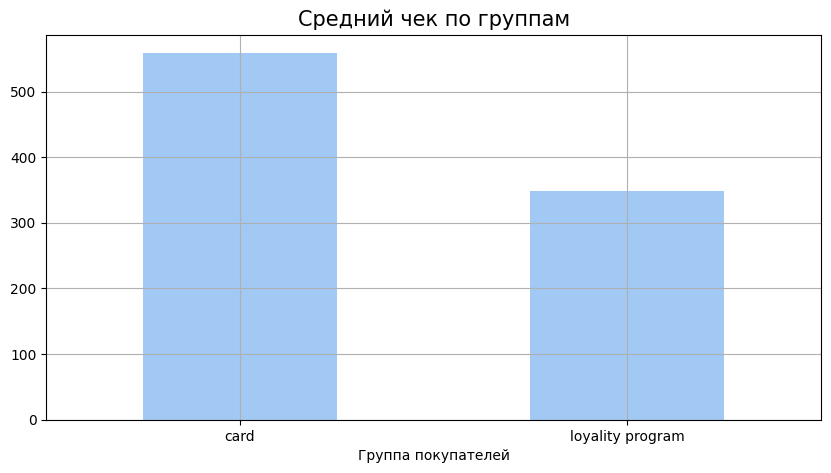

In [81]:
(data.query('card != "no card"')
 .groupby(['card', 'purchase_id'])
 .agg({'total_sum': 'sum'})
 .reset_index()
 .groupby('card').agg({'total_sum': 'mean'})
 .plot(grid=True, kind='bar', rot=0, figsize=(10,5), legend=False)
)


plt.xlabel('Группа покупателей')
plt.title('Средний чек по группам', fontsize=15)
plt.show()

Средний чек у покупателей с обычной картой постоянного покупателя значительно выше, чем у покупателей с подключенной программой лояльности. С программой чек примерно на одном уровне с чеком покупателей без карт.

#### Средняя сумма, полученная с покупателя по группам за весь период

Посмотрим сколько в среднем денег принес покупатель за изучаемый период в каждой группе.

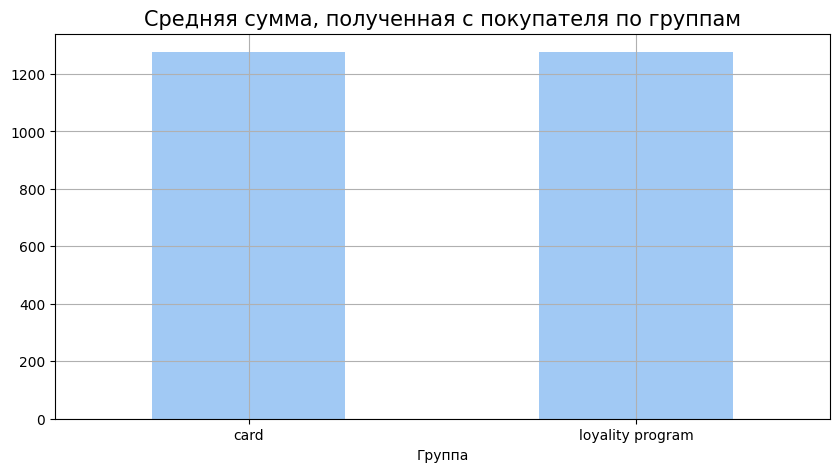

In [82]:
# Посчитаем какую прибыль принес каждый покупатель, с разбивкой по группам
total_sum_group = data.query('card != "no card"').groupby(['card', 'customer_id']).agg({'total_sum': 'sum'})
# Посчитаем среднюю сумму, полученную с покупателя в каждой группе и визуализируем
total_sum_group.reset_index().groupby('card').agg({'total_sum': 'mean'}).plot(grid=True, kind='bar', rot=0, figsize=(10,5), legend=False)
plt.xlabel('Группа')
plt.title('Средняя сумма, полученная с покупателя по группам', fontsize=15)
plt.show()

В среднем за изучаемый период покупатели с картой с программой и без нее принесли магазину около 1200 рублей. Напомним, что  покупки с картой лояльности совершались чаще, чем без программы. Поэтому несмотря на более низкий средний чек, общая сумма, полученная с покупателя по программе и без нее получилась примерно одинаковой.

Так как каждую покупку, совершенную без карты постоянного покупателя  мы приравняли к одному покупателю, можно сделать вывод о том, что среднее значение чека у таких покупателей, несмотря на массовые закупки, было около 300р.

#### Изменение величины среднего чека покупателя по неделям

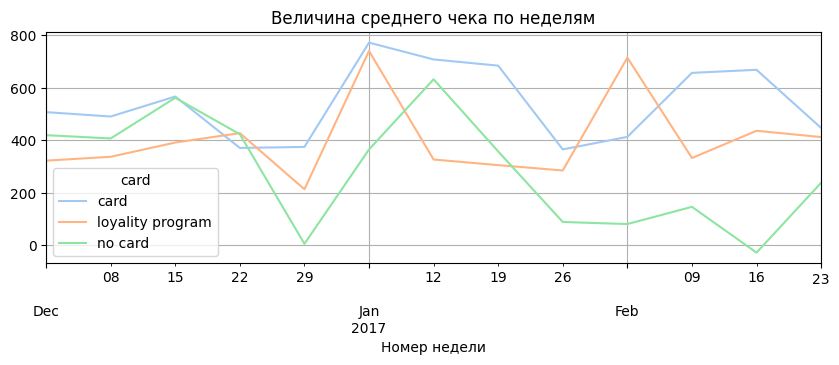

In [83]:
( data.pivot_table(index='week', columns='card', values='total_sum', aggfunc='sum') / 
 data.pivot_table(index='week', columns='card', values='purchase_id', aggfunc='nunique')
).plot(grid=True, figsize=(10,3))

plt.xlabel('Номер недели')
plt.title('Величина среднего чека по неделям');

Величина среднего чека по неделям первый месяц изменяется примерно одинаково у всех групп. После спада в новогодние праздники в каждой группе идут несопоставимые друг с другом провалы и подъемы.

#### Распределение дохода по магазинам

Мы уже выяснили что самое большое количество покупателей было в нулевом магазине. Посмотрим как распределен доход по торговым точкам

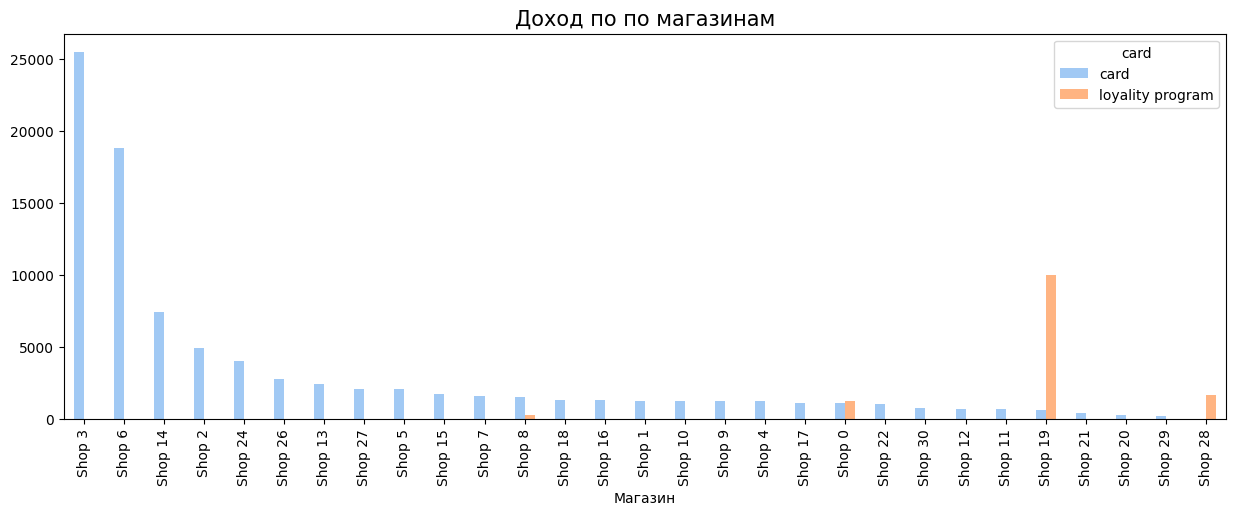

In [84]:
(
    (
    (data.query('card != "no card"').pivot_table(index='shop_id', columns='card', values='total_sum', aggfunc='sum')) /
    (data.query('card != "no card"').pivot_table(index='shop_id', columns='card', values='customer_id', aggfunc='nunique')
    )
    ).sort_values('card', ascending=False)
     .plot(figsize=(15,5), kind='bar')
)

plt.xlabel('Магазин')
plt.title('Доход по по магазинам', fontsize=15);

Несмотря на большое количество покупателей в магазине Shop 0 доход он приносит маленький. Остальные магазины в большинстве своем приносят доход выше, чем Shop 0. Таким образом исключать из анализа магазины с мизерным количеством покупателей было нецелесообразно, (хотя желание такое было) - эти магазины дают основную выручку.

#### LTV
Посмотрим сколько денег в среднем приносят покупатели со всех своих покупок. Для сравнения построим два графика LTV - с ежемесячной платой за программу лояльности и без.

In [85]:
# Профили пользователей
profiles_with_loy_pay = get_profiles(data.query('card != "no card"'))
profiles_without_loy_pay = get_profiles(data.query('item_id !="loyalty" and card !="no card"'))
# Стоимость каждой покупки по датам
orders_with_loy_pay = get_orders(data.query('card != "no card"'))
orders_without_loy_pay = get_orders(data.query('item_id !="loyalty" and card !="no card"'))

Установим дату момента анализа как 28 февраля 2017г - конец сбора данных.

Горизонт анализа - 30 дней.

In [86]:
observation_date = dt.datetime(2017, 2, 28).date()
horizon_days = 30

Построим графики

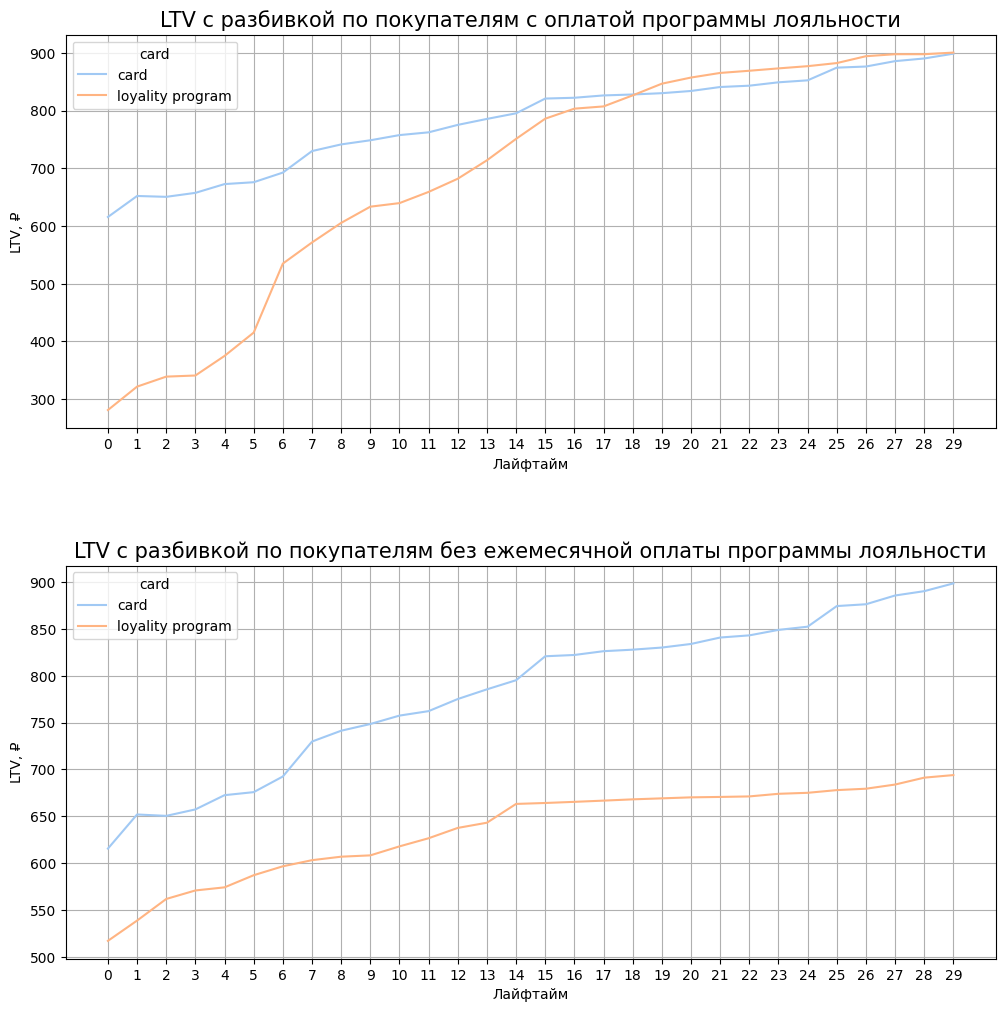

In [87]:
plt.figure(figsize=(12, 12))
ltv_raw, ltv, ltv_history = get_ltv(
    profiles_with_loy_pay, orders_with_loy_pay, observation_date, horizon_days, dimensions=['card']
)

report = ltv.drop(columns=['cohort_size'])
report.T.plot(grid=True, 
              #figsize=(10, 5),
              xticks=list(report.columns.values), ax=plt.subplot(2, 1, 1) )
plt.title('LTV с разбивкой по покупателям с оплатой программы лояльности', fontsize=15)
plt.ylabel('LTV, ₽')
plt.xlabel('Лайфтайм')

ltv_raw, ltv, ltv_history = get_ltv(
    profiles_without_loy_pay, orders_without_loy_pay, observation_date, horizon_days, dimensions=['card']
)

report = ltv.drop(columns=['cohort_size'])
report.T.plot(grid=True, 
             # figsize=(10, 5), 
              xticks=list(report.columns.values), ax=plt.subplot(2, 1, 2) )
plt.subplots_adjust(hspace = 0.35)
plt.title('LTV с разбивкой по покупателям без ежемесячной оплаты программы лояльности', fontsize=15)
plt.ylabel('LTV, ₽')
plt.xlabel('Лайфтайм')
plt.show()

Без оплаты программы лояльности покупатели с подключенной программой заметно проигрывают покупателям без программы. Однако при добавлении дополнительных 200р ежемесячно покупателям с программой лояльности показатели к концу рассматриваемого периода выравниваются, и иногда даже превосходят показатели покупателей с обычной картой постоянного покупателя. 

Возможно в данные вносит свой корректив метод, выбранный нами для оплаты программы лояльности. Может быть, если добавить покупателям 200р в первый чек месяца, а не первого числа, визуализация выглядела бы иначе. Сейчас на графике с ежемесячной оплатой программы лояльности в нулевой лайфтайм график тяготеет к 200р, так как в первый день месяца у всех покупателей с картой лояльности проходит чек с суммой в 200р.

#### Вывод
* Средний чек у покупателей с картой лояльности ниже, чем у покупателей с обычной картой.

* Однако за счет числа покупок количество средств, которые в среднем приносит один покупатель магазинам у покупателей с программой лояльности и без практически одинаковое.

* Несмотря на то, что Shop 0 в лидерах по количеству покупателей, в доходности он уступает более чем половине остальных магазинов. По доходу от покупателей с обычной картой сильно выделяются Shop 3 и Shop 6, а по дохоу от покупателей с программой лояльности Shop 19.

* Из графика LTV следует что средний ежемесячный доход у покупателей с программой лояльности и без нее отличается не сильно, хоть у обладателей программы лояльности и наблюдается стремительный рост. LTV покупателей с программой лояльности и без нее в конце периода сравниваются.


### **Общие выводы**
**Ключевые моменты:**
- Программу лояльности подключили треть обладателей карты постоянного покупателя
- Наибольшее количество покупателей совершили покупатели с подключенной программой лояльности.
- Средний чек покупателей с подключенной программой лояльности ниже, чем средний чек покупателей с обычной картой.
- LTV двух групп: покупатели с подключенной программой лояльности и без нее примерно одинаковый.

**Инсайты:**
- Предоставленные данные не соответсвуют данным, которые могли бы быть получены с кассовых аппаратов: в данных имеется внушительное число позиций с нулевым количеством, непонятных возвратов и комиссий.
- Данные распределены по магазинам неравномерно, что может говорить о некорректном снятии даных. Например, доходность и количество проданных единиц товара по позициям не соответсвует распределению покупателей по магазинам.
- Продажи строительного магазина падают перед Новым годом, однако восстанавливаются уже в первую неделю января.

## **Проверка гипотез**

### **Средний чек**
Получим данные о величине среднего чека по группам. Возьмем покупателей с обычной картой постоянного покупателя и с подключенной программой лояльности:

In [88]:
#данные о среднем чеке покупателей с программой лояльности
total_bill_loy = data.query('card == "loyality program"').groupby('purchase_id').agg({'total_sum':'sum'})
#данные о среднем чеке покупателей без программы лояльности
total_bill_not_loy = data.query('card == "card"').groupby('purchase_id').agg({'total_sum':'sum'})

#### Проверка нормальности распределения и выбор метода проведения статистического теста

Мы выяснили что у покупателей с подключенной программой лояльности средний чек ниже, чем у покупателей с обычной картой постоянного покупателя. Выясним есть ли между двух групп значимые статистические различия.


Для определения метода проведения теста выясним как распределены значения средних чеков. Воспользуемся Критерием Шапиро-Уилка.

**Нулевая гипотеза:** 

Данные распределены **нормально**.

**Альтернативная гипотеза:** 

Данные распределены **не нормально**.

**Критический уровень статистической значимости: 0,05** 

In [89]:
shapiro_t(total_bill_loy['total_sum'], 'с подключенной программой лояльности')

Проверка данных о среднем чеке группы покупателей с подключенной программой лояльности на нормальность распределения.
p-значение:  0.000


Отвергаем нулевую гипотезу: **распределение не нормально**

In [90]:
shapiro_t(total_bill_not_loy['total_sum'], 'без подключенной программы лояльности')

Проверка данных о среднем чеке группы покупателей без подключенной программы лояльности на нормальность распределения.
p-значение:  0.000


Отвергаем нулевую гипотезу: **распределение не нормально**

Так как распределение не нормально и мы сравниваем две группы: с программой лояльности и без; выберем для проведения статистического теста **тест Уилкоксона-Манна-Уитни**.

**С критическим уровнем статистической значимости: 0,05** 

#### Проверка гипотезы

**Нулевая гипотеза:** 

Между величиной среднего чека у покупателей с подключенной программой лояльности и без нее **нет статистических различий**.

**Альтернативная гипотеза:** 

Между величиной среднего чека у покупателей с подключенной программой лояльности и без нее **есть статистические различия**.

In [91]:
mann_whitney_u(total_bill_loy['total_sum'], total_bill_not_loy['total_sum'])

P-value:  0.000


Отвергаем нулевую гипотезу: **разница статистически значима**

Таким образом мы подтвердили, что разница в среднем чеке статистически значима.

### **Число покупок**
Получим данные о количестве покупок (чеков) у каждого покупателя по группам. 

Возьмем покупателей с обычной картой постоянного покупателя и с подключенной программой лояльности. Брать покупателей без карты нецелесообразно, так как мы искусственно присвоили им соответсвие 1 покупка = 1покупатель.

In [92]:
#данные о среднем чеке покупателей с программой лояльности
cnt_of_purchase_loy = data.query('card == "loyality program"').groupby('customer_id').agg({'purchase_id':'nunique'})
#данные о среднем чеке покупателей без программы лояльности
cnt_of_purchase_not_loy = data.query('card == "card"').groupby('customer_id').agg({'purchase_id':'nunique'})

#### Проверка нормальности распределения и выбор метода проведения статистического теста

Ранее мы выяснили что покупатели с подключенной программой лояльности совершают больше покупок, чем покупатели с обычной картой постоянного покупателя. Выясним насколько значимы различия между двумя группами.

Для определения метода проведения теста выясним как распределены значения средних чеков. Воспользуемся Критерием Шапиро-Уилка.

**Нулевая гипотеза:** 

Данные распределены **нормально**.

**Альтернативная гипотеза:** 

Данные распределены **не нормально**.

In [93]:
shapiro_t(cnt_of_purchase_loy['purchase_id'], 'с подключенной программой лояльности')

Проверка данных о среднем чеке группы покупателей с подключенной программой лояльности на нормальность распределения.
p-значение:  0.000


Отвергаем нулевую гипотезу: **распределение не нормально**

In [94]:
shapiro_t(cnt_of_purchase_not_loy['purchase_id'], 'без подключенной программы лояльности')

Проверка данных о среднем чеке группы покупателей без подключенной программы лояльности на нормальность распределения.
p-значение:  0.000


Отвергаем нулевую гипотезу: **распределение не нормально**

Так как распределение не нормально и мы сравниваем две группы: с программой лояльности и без, выберем для проведения статистического теста **тест Уилкоксона-Манна-Уитни**.

**С критическим уровнем статистической значимости: 0,05** 

#### Проверка гипотезы

**Нулевая гипотеза:** 

Между средним количеством покупок у покупателей с подключенной программой лояльности и без нее **нет статистических различий**.

**Альтернативная гипотеза:** 

Между средним количеством покупок у покупателей с подключенной программой лояльности и без нее **есть статистические различия**.

In [95]:
mann_whitney_u(cnt_of_purchase_loy['purchase_id'], cnt_of_purchase_not_loy['purchase_id'])

P-value:  0.000


Отвергаем нулевую гипотезу: **разница статистически значима**

Действительно, покупатели с подключенной программой лояльности совершают больше покупок в магазинах.

## **Общий вывод и рекомендации**

### Вывод по данным:

- Данные собраны не очень качественно, не хватает данных об оплате программы лояльности.
- В данных встречается нулевое количество товара, непонятно откуда берутся эти позиции.
- По данным в одном чеке одна и та же позиция может быть пробита несколько раз в разном количестве.
- Ко многим позициям из прайса в данных дано несколько цен, и нет никаких маркировок для какого заказа какую цену применять.
- Айди многих товаров наводят на мысли о том, что данные собраны не только с кассовых аппаратов.

В качестве рекомендации для последующего сбора данных хотелось бы предложить учесть следующие моменты:
- Учитывать оплату программы лояльности
- Указывать чем отличаются цены в прайсе или, как вариант, фиксировать итоговую стоимость каждой позиции в чеке.
- Внимательнее отнестись к источнику данных. Откуда мы получаем данные? С кассовых аппаратов или все же это общие данные о движении средств в магазинах?
- Уточнить, какие скидки и акции работают для разных категорий покупателей. Как они проводятся через кассу.

### Вывод по исследованию: 

- Программу лояльности подключили треть обладателей карты постоянного покупателя;
- Наибольшее количество покупок совершили покупатели с подключенной программой лояльности;
- Средний чек покупателей с подключенной программой лояльности ниже, чем чек покупателей с обычной картой.
- LTV двух групп за месяц к концу лайфтайма в 30 дней становится равным.

Проверка гипотез подтвердила, основные выводы исследования.

Нельзя сказать, что программа лояльности эффективна. Она не принесла магазину больше дохода. Но и нельзя сказать что она убыточна. Таким образом после коррекции внутренней коррекции программы, возможно её продление. 

В качестве рекомендаций по программе лояльности:
- Уточнить метод оплаты программы лояльности;
- Настойчиво предлагать покупателям без карты её приобрести, это повысит и количество иденцифицируемых покупателей и должно повысить вероятность приобретения программы лояльности; 
- Ввести тестовый период программы лояльности, что бы завлечь покупателя;
- Найти причины неэффектиности программы, возможно провести дополнительное исследование самой программы лояльности:
    - Был ли повышен спрос на товары, которые были акционными специально для покупателей с программой лояльности;
    - Смогли ли покупатели воспользоваться бонусами или получить подарки;
    - Как осуществлялась рассылка уведомлений об акциях (в какое время, на какие позиции).